In [10]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set the maximum sequence length and vocabulary size
seq_length = 30
vocab_size = 10000

In [11]:
# Load the training data and remove unnecessary columns
data = pd.read_csv('train.csv')
data.drop(['tid1', 'tid2', 'id'], axis=1, inplace=True)
data.dropna(inplace=True)

In [12]:
# Make text lowercase and tokenize using Keras Tokenizer
data['title1_en'] = data['title1_en'].apply(lambda x: x.lower())
data['title2_en'] = data['title2_en'].apply(lambda x: x.lower())
text_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token='')
text_tokenizer.fit_on_texts(data['title1_en'] + data['title2_en'])
title1_seq = text_tokenizer.texts_to_sequences(data['title1_en'])
title2_seq = text_tokenizer.texts_to_sequences(data['title2_en'])
title1_seq = tf.keras.preprocessing.sequence.pad_sequences(title1_seq, maxlen=seq_length)
title2_seq = tf.keras.preprocessing.sequence.pad_sequences(title2_seq, maxlen=seq_length)

# Encode labels as one-hot vectors
label_dict = {'agreed': 0, 'disagreed': 1, 'unrelated': 2}
y_data = data.label.apply(lambda x: label_dict[x])
y_data = np.asarray(y_data).astype('float32')
y_data = tf.keras.utils.to_categorical(y_data)

In [13]:
# Split data into training and validation sets
title1_train, title1_val, title2_train, title2_val, y_train, y_val = train_test_split(title1_seq, title2_seq, y_data, test_size=0.2)

In [14]:
# Create a Siamese model with GRU layers
input1 = tf.keras.Input(shape=(seq_length,))
input2 = tf.keras.Input(shape=(seq_length,))
embed1 = tf.keras.layers.Embedding(vocab_size, 128)(input1)
embed2 = tf.keras.layers.Embedding(vocab_size, 128)(input2)
gru1 = tf.keras.layers.GRU(64)(embed1)
gru2 = tf.keras.layers.GRU(64)(embed2)
merged = tf.keras.layers.concatenate([gru1, gru2])
output_layer = tf.keras.layers.Dense(3, activation='softmax')(merged)
siamese_model = tf.keras.Model(inputs=[input1, input2], outputs=output_layer)

In [17]:
# Compile and train the Siamese model
optimizer = tf.keras.optimizers.Adam()
siamese_model.compile(optimizer=optimizer, loss=tf.keras.metrics.categorical_crossentropy, metrics=['accuracy'])
training_history = siamese_model.fit(x=[title1_train, title2_train], y=y_train, batch_size=64, epochs=10, validation_data=([title1_val, title2_val], y_val))


Epoch 1/10
3206/3206 [==============================] - 368s 113ms/step - loss: 0.4806 - accuracy: 0.7751 - val_loss: 0.4375 - val_accuracy: 0.7992
Epoch 2/10
3206/3206 [==============================] - 356s 111ms/step - loss: 0.3770 - accuracy: 0.8331 - val_loss: 0.4165 - val_accuracy: 0.8136
Epoch 3/10
3206/3206 [==============================] - 354s 110ms/step - loss: 0.3189 - accuracy: 0.8622 - val_loss: 0.4159 - val_accuracy: 0.8203
Epoch 4/10
3206/3206 [==============================] - 356s 111ms/step - loss: 0.2722 - accuracy: 0.8842 - val_loss: 0.4314 - val_accuracy: 0.8212
Epoch 5/10
3206/3206 [==============================] - 358s 112ms/step - loss: 0.2339 - accuracy: 0.9022 - val_loss: 0.4486 - val_accuracy: 0.8254
Epoch 6/10
3206/3206 [==============================] - 356s 111ms/step - loss: 0.2019 - accuracy: 0.9160 - val_loss: 0.4788 - val_accuracy: 0.8222
Epoch 7/10
3206/3206 [==============================] - 359s 112ms/step - loss: 0.1748 - accuracy: 0.9287 - val_

<ipython-input-18-ef92472b7e88>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


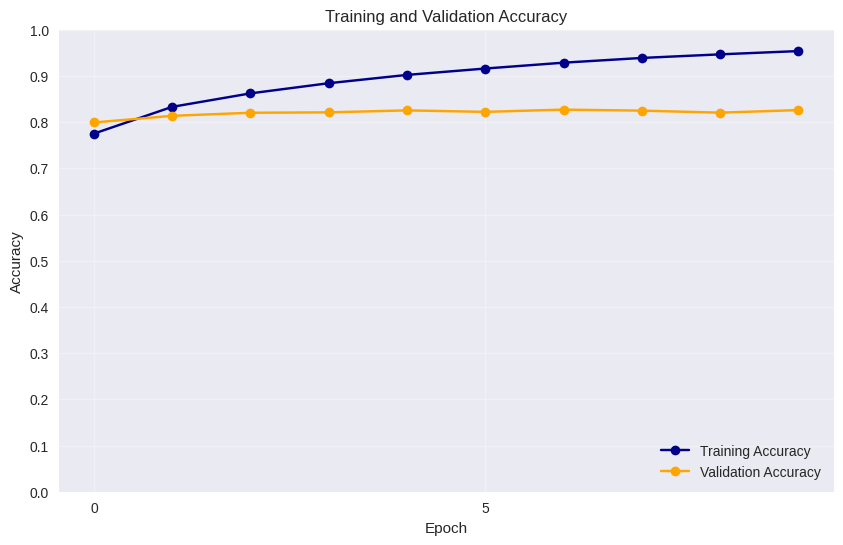

In [18]:
# Set the plot style
plt.style.use('seaborn')

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(training_history.history['accuracy'], 'o-', label='Training Accuracy', color='darkblue')
plt.plot(training_history.history['val_accuracy'], 'o-', label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, len(training_history.history['accuracy']), 5)) 
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(alpha=0.3)
plt.legend(loc='lower right')   
plt.tight_layout
plt.show()

<ipython-input-19-397745aacb27>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


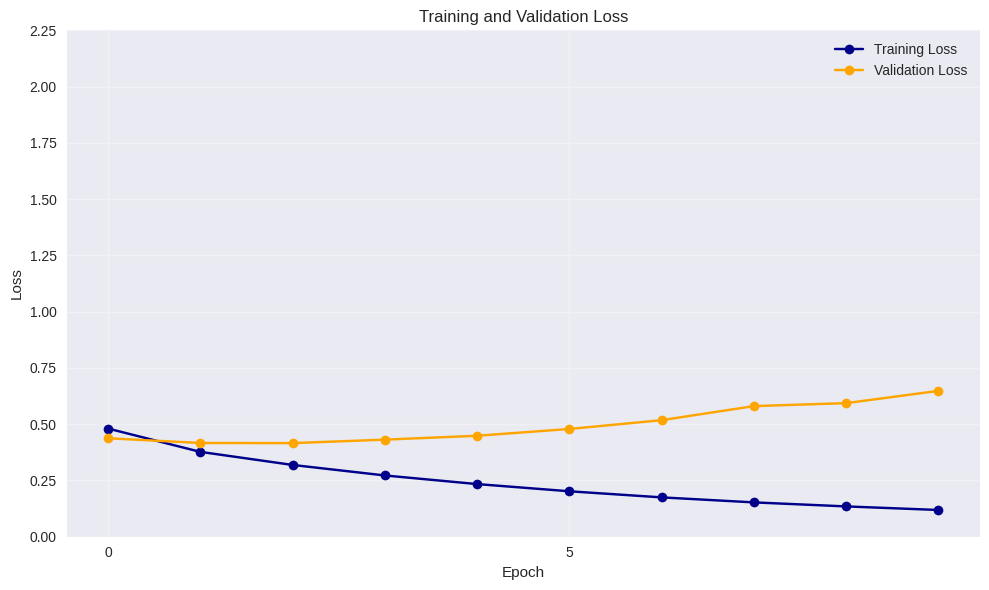

In [19]:
# Set the plot style
plt.style.use('seaborn')

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(training_history.history['loss'], 'o-', label='Training Loss', color='darkblue')
plt.plot(training_history.history['val_loss'], 'o-', label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, len(training_history.history['loss']), 5))
plt.yticks(np.arange(0, 2.5, 0.25))
plt.grid(alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [20]:
# Load test data and make predictions
test_data = pd.read_csv('test.csv')

test_title1 = text_tokenizer.texts_to_sequences(test_data['title1_en'])
test_title2 = text_tokenizer.texts_to_sequences(test_data['title2_en'])
test_title1 = tf.keras.preprocessing.sequence.pad_sequences(test_title1, maxlen=seq_length)
test_title2 = tf.keras.preprocessing.sequence.pad_sequences(test_title2, maxlen=seq_length)    
predictions = siamese_model.predict([test_title1, test_title2])


2004/2004 [==============================] - 25s 12ms/step


In [35]:
# Convert predicted probabilities to labels
inverse_labels = {0: 'agreed', 1: 'disagreed', 2: 'unrelated'}
for j in range(len(predictions)):
    test_data.loc[j, 'label'] = inverse_labels[np.argmax(predictions[j])]

In [39]:

# Prepare the submission DataFrame with 'id' and 'label' columns
submission_data = test_data[['id', 'label']]

# Save the submission data to a CSV file named 'submission.csv'
submission_file_name = 'submission.csv'
submission_data.to_csv(submission_file_name, index=False)
test_data.head()

,id,title1_en,title2_en,label
0,256442,"The great coat brother Zhu Zhu Wen, in the man...","Lin xinsheng after the birth of ""hard milking,...",agreed
1,256443,NASA reveals facts about UFO wreckage found on...,"The UFO found in Yuancun, Jiaocheng County, Sh...",unrelated
2,256444,The hollow tomatoes are loaded with hormones.,"Li chenfan bingbing home photos, netizen: this...",unrelated
3,256445,Ange Pavilion Geoshui: How accurate is Matrimo...,Master one: the eight-character presumption of...,unrelated
4,256446,A 50-year-old bus-bus blows up an 8-year-old c...,< i > Joe Johnson's disgruntled timing and ord...,unrelated


In [41]:
# Prepare the submission DataFrame with 'id' and 'label' columns
submission_data = test_data[['id', 'label']]

# Save the submission data to a CSV file named 'submission.csv'
submission_file_name = 'submission.csv'
submission_data.to_csv(submission_file_name, index=False)

# Download the file (if using Google Colab)
try:
    from google.colab import files
    files.download(submission_file_name)
except ImportError:
    print(f"The submission file '{submission_file_name}' has been saved in the working directory.")




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>